<a href="https://colab.research.google.com/github/jcheigh/mech-interp/blob/main/Neel_Nanda_Implementing_GPT_2_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Neel Nanda Implementing GPT-2 From Scratch

This is me walking through Neel Nanda's [GPT-2 From Scratch](https://www.youtube.com/watch?v=dsjUDacBw8o&list=PL7m7hLIqA0hoIUPhC26ASCVs_VrqcDpAz&index=2). Since I already have familiarity with the transformer, this won't be super in depth. This code follows [Neel's implementation](https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/clean-transformer-demo/Clean_Transformer_Demo_Template.ipynb#scrollTo=5R6_pPCtOFpj).

In [4]:
try:
  import google.colab
  IN_COLAB = True
  %pip install git+https://github.com/neelnanda-io/Easy-Transformer.git@clean-transformer-demo
  # Install another version of node that makes PySvelte work way faster
  !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
  %pip install git+https://github.com/neelnanda-io/PySvelte.git
  %pip install fancy_einsum
  %pip install einops
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

  Cloning https://github.com/neelnanda-io/Easy-Transformer.git (to revision clean-transformer-demo) to /tmp/pip-req-build-aphkw06k
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/Easy-Transformer.git /tmp/pip-req-build-aphkw06k
  Running command git checkout -b clean-transformer-demo --track origin/clean-transformer-demo
  Switched to a new branch 'clean-transformer-demo'
  Branch 'clean-transformer-demo' set up to track remote branch 'clean-transformer-demo' from 'origin'.
  Resolved https://github.com/neelnanda-io/Easy-Transformer.git to commit 1f25219e631aeb478d17075d47274db32c874e88
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━

In [5]:
import einops
from fancy_einsum import einsum
from dataclasses import dataclass
from easy_transformer import EasyTransformer
import torch
import torch.nn as nn
import numpy as np
import math
from easy_transformer.utils import get_corner, gelu_new, tokenize_and_concatenate
import tqdm.auto as tqdm

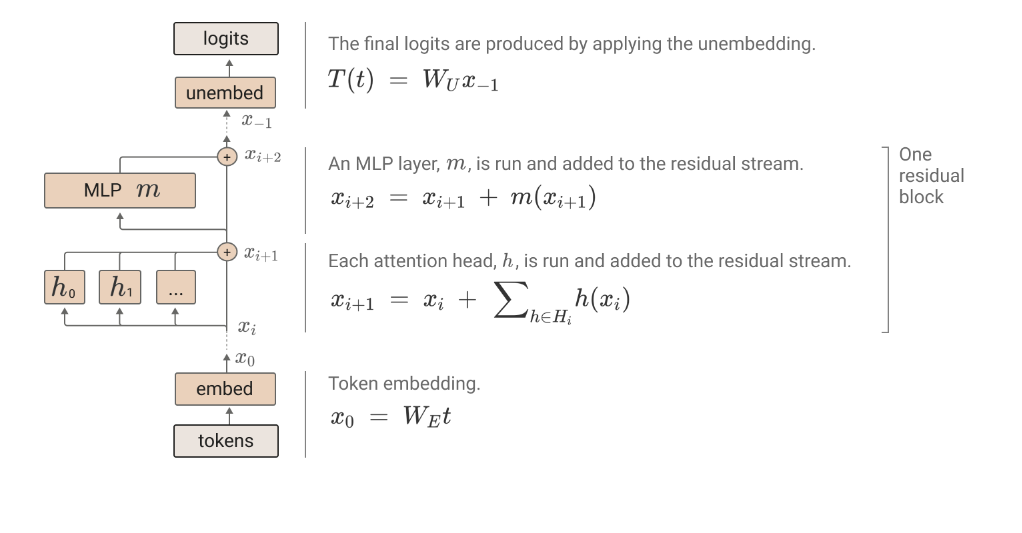

**Input Outputs**
- transformers model text, and specifically they will input tokens and output logits.
- Causal attention means that it can only move info forwards in the sequence
- Does same processing with same parameters at each point in sequence in parallel, then uses attention to move that info around

**Model Input:**

1. Fix a vocabulary, then convert to integer, then tokenize, then one hot, then use an embedding as a lookup table to map integer to vector
- Characters lose lots of structure, so we do byte pair encoding
- [Byte Pair Encoding](https://huggingface.co/learn/nlp-course/en/chapter6/5)
    - Take corpus (post normalization), separate into symbols used to make these (characters), then continue merging on most frequent pair of tokens until reach desired vocabulary length
    - Really messed up- think about math

**Model Output:**

- Probability distribution over next tokens (for each prefix of the sequence, i.e. given n tokens we make n next token predictions)
- Thus, the output is a tensor of logits with shape (n, d_vocab, or really batch, n, d_vocab) (each of n rows is a probability distribution, i.e. you applied softmax over rows)
- You can sample from these, feed this into input and continue to run again (autoregressive)


**High Level Architecture:**

- Inputs tokens as integers, embedding is lookup table mapping tokens to vector
    - Live in the *residual stream*
- The residual stream is the central object of the transformer. We have x0, x1, …. Here each layer of model reads in sum of previous layer, then output adds onto that
- He thinks most computation is like a head in layer i, MLP in layer j, etc.
- We have a series of n_layers transformer blocks, which has an attention layer and an MLP layer, but a transformer has k layers if it has k blocks

**Attention:**

- moves info from prior info to current token, done for every token in parallel using the same parameter. The only difference is that we only look backwards.
- For each destination token, a probability distribution of prior source tokens (including current one), weighting how much information to copy
    - Figuring out which source tokens to copy info from is a separate circuit from figuring out how to copy that information.
- So, for each position, there is a residual stream vector
- The way we copy information only depends on the learned parameters (not on tokens), but what info we copy depends on source token’s residual stream
- Residual stream is really just how model remembers things, moves information between layers, moves between positions
- Each head works independently, additively, and in parallel- each with own parameters, attention pattern, and own information how to copy things from source to destination
- Each head usually has d_head = d_model / n_heads
- Btw- copy = apply linear map

**MLPs:**

- Linear map that usually goes from small to big hidden layer, apply GeLU, big to small
- Specifically hidden layer will have d_mlp = 4 d_model
- Once attention has moved relevant information to a single position in residual stream- MLPs can do computation- reasoning, lookup information, etc.

**Unembed:**

- Apply a linear map, going from final residual stream to a vector of logits
- Note- attention calculation from token 5 to token 1 and token 5 to token 2 are the same by default. You need positional embeddings, which are bad: one way is learned, absolute positional embeddings: mapping index of position to embedding vector and add
- The reason why we always add is because the residual stream is shared memory and likely under significant superposition (we compress more info in there than we have dimensions)

In [1]:
batch = 1 # num samples run at once
position = 35 # tokens in each sample
d_model = 768 # res stream dim
n_heads = 12 # num attn heads
n_layers = 12 # num layers (blocks)
d_mlp = 3072 #(4 * d_model),  mlp layer
d_head = 64 #(d_model / n_heads), dim per attn head

In [6]:
reference_gpt2 = EasyTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Moving model to device:  cpu
Finished loading pretrained model gpt2-small into EasyTransformer!


In [7]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = reference_gpt2.to_tokens(reference_text)
print(tokens)
print(tokens.shape)
print(reference_gpt2.to_str_tokens(tokens))

logits, cache = reference_gpt2.run_with_cache(tokens)
print(logits.shape)

log_probs = logits.log_softmax(dim=-1)
probs = logits.log_softmax(dim=-1)
print(log_probs.shape)
print(probs.shape)

next_token = logits[0, -1].argmax(dim=-1)
print(next_token)

next_tokens = torch.cat([tokens, torch.tensor(next_token, dtype=torch.int64)[None, None]], dim=-1)
new_logits = reference_gpt2(next_tokens)
print("New Input:", next_tokens)
print(next_tokens.shape)
print("New Input:", reference_gpt2.tokenizer.decode(next_tokens[0]))

print(new_logits.shape)
print(new_logits[-1, -1].argmax(-1))

print(reference_gpt2.tokenizer.decode(new_logits[-1, -1].argmax(-1)))


tensor([[50256,    40,   716,   281,  4998,  1960,   382, 19741,    11,   875,
         12342,    12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,
            13,  1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,
          1011,   625,   262,   995,     0]])
torch.Size([1, 35])
['<|endoftext|>', 'I', ' am', ' an', ' amazing', ' aut', 'ore', 'gressive', ',', ' dec', 'oder', '-', 'only', ',', ' G', 'PT', '-', '2', ' style', ' transformer', '.', ' One', ' day', ' I', ' will', ' exceed', ' human', ' level', ' intelligence', ' and', ' take', ' over', ' the', ' world', '!']
torch.Size([1, 35, 50257])
torch.Size([1, 35, 50257])
torch.Size([1, 35, 50257])
tensor(314)


<ipython-input-7-6845fc4d561b>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_tokens = torch.cat([tokens, torch.tensor(next_token, dtype=torch.int64)[None, None]], dim=-1)


New Input: tensor([[50256,    40,   716,   281,  4998,  1960,   382, 19741,    11,   875,
         12342,    12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,
            13,  1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,
          1011,   625,   262,   995,     0,   314]])
torch.Size([1, 36])
New Input: <|endoftext|>I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world! I
torch.Size([1, 36, 50257])
tensor(716)
 am


In [8]:
for name, param in reference_gpt2.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(name, param.shape)

embed.W_E torch.Size([50257, 768])
pos_embed.W_pos torch.Size([1024, 768])
blocks.0.ln1.w torch.Size([768])
blocks.0.ln1.b torch.Size([768])
blocks.0.ln2.w torch.Size([768])
blocks.0.ln2.b torch.Size([768])
blocks.0.attn.W_Q torch.Size([12, 768, 64])
blocks.0.attn.W_K torch.Size([12, 768, 64])
blocks.0.attn.W_V torch.Size([12, 768, 64])
blocks.0.attn.W_O torch.Size([12, 64, 768])
blocks.0.attn.b_Q torch.Size([12, 64])
blocks.0.attn.b_K torch.Size([12, 64])
blocks.0.attn.b_V torch.Size([12, 64])
blocks.0.attn.b_O torch.Size([768])
blocks.0.mlp.W_in torch.Size([768, 3072])
blocks.0.mlp.b_in torch.Size([3072])
blocks.0.mlp.W_out torch.Size([3072, 768])
blocks.0.mlp.b_out torch.Size([768])
ln_final.w torch.Size([768])
ln_final.b torch.Size([768])
unembed.W_U torch.Size([768, 50257])
unembed.b_U torch.Size([50257])


In [9]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12

cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


In [10]:
def rand_float_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg)
    random_input = torch.randn(shape)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    print("Output shape:", output.shape)
    print()
    return output

def rand_int_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg)
    random_input = torch.randint(100, 1000, shape)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    print("Output shape:", output.shape)
    print()
    return output

def load_gpt2_test(cls, gpt2_layer, input_name, cache_dict=cache.cache_dict):
    cfg = Config(debug=True)
    layer = cls(cfg)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    # Allow inputs of strings or tensors
    if isinstance(input_name, str):
        reference_input = cache_dict[input_name]
    else:
        reference_input = input_name
    print("Input shape:", reference_input.shape)
    output = layer(reference_input)
    print("Output shape:", output.shape)
    reference_output = gpt2_layer(reference_input)
    print("Reference output shape:", reference_output.shape)

    comparison = torch.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
    return output

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))
        self.b = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, residual):
        # residual: [batch, position, d_model]
        residual = residual - einops.reduce(residual, "batch position d_model -> batch position 1", "mean")
        scale    = (einops.reduce(residual.pow(2), 'batch position d_model -> batch position 1', "mean") + cfg.layer_norm_eps).sqrt()
        residual /= scale
        return residual * self.w + self.b

In [12]:
_ = rand_float_test(LayerNorm, [2, 4, 768])
_ = load_gpt2_test(LayerNorm, reference_gpt2.ln_final, "blocks.11.hook_resid_post")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


In [14]:
### testing tensor[tens, :]

x = torch.empty((5, 3))
nn.init.normal(x, std=0.2)
y = torch.tensor([[0,1,0,0],[0,0,1,0]])


add_line = lambda n=20 : print('='*n)

print(f'x.size: {x.size()}')
print(f'x: {x}')
add_line()

print(f'y.size: {y.size()}')
print(f'y: {y}')
add_line()

print(f'x[y].size: {x[y].size()}')
print(f'x[y]: {x[y]}')
add_line()
print(f'x[y, :].size: {x[y, :].size()}')
print(f'x[y, :]: {x[y, :]}')

add_line()
print(f'x[:, y].size: {x[:,y].size()}')
print(f'x[:, y]: {x[:,y]}')


x.size: torch.Size([5, 3])
x: tensor([[-0.1508,  0.0924, -0.1618],
        [ 0.0753,  0.0714,  0.0711],
        [ 0.4369,  0.0905,  0.0978],
        [ 0.2541, -0.1607,  0.5345],
        [ 0.1345, -0.1003, -0.2897]])
y.size: torch.Size([2, 4])
y: tensor([[0, 1, 0, 0],
        [0, 0, 1, 0]])
x[y].size: torch.Size([2, 4, 3])
x[y]: tensor([[[-0.1508,  0.0924, -0.1618],
         [ 0.0753,  0.0714,  0.0711],
         [-0.1508,  0.0924, -0.1618],
         [-0.1508,  0.0924, -0.1618]],

        [[-0.1508,  0.0924, -0.1618],
         [-0.1508,  0.0924, -0.1618],
         [ 0.0753,  0.0714,  0.0711],
         [-0.1508,  0.0924, -0.1618]]])
x[y, :].size: torch.Size([2, 4, 3])
x[y, :]: tensor([[[-0.1508,  0.0924, -0.1618],
         [ 0.0753,  0.0714,  0.0711],
         [-0.1508,  0.0924, -0.1618],
         [-0.1508,  0.0924, -0.1618]],

        [[-0.1508,  0.0924, -0.1618],
         [-0.1508,  0.0924, -0.1618],
         [ 0.0753,  0.0714,  0.0711],
         [-0.1508,  0.0924, -0.1618]]])
x[:, y].s

<ipython-input-14-3cee7b59118f>:4: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(x, std=0.2)


In [15]:
class Embed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens):
        # tokens: [batch, position]
        return self.W_E[tokens, :] # result batch x position x d_model

rand_int_test(Embed, [2, 4])
load_gpt2_test(Embed, reference_gpt2.embed, tokens)


Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


tensor([[[ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207],
         [ 0.1474, -0.0959,  0.1430,  ...,  0.1030, -0.0625, -0.1131],
         [ 0.1596, -0.1249,  0.1148,  ...,  0.2558,  0.0196,  0.0145],
         ...,
         [-0.0393,  0.0050,  0.0421,  ..., -0.0477,  0.0670, -0.0471],
         [-0.1488,  0.1519,  0.0056,  ..., -0.3107,  0.2073,  0.0377],
         [-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453]]],
       grad_fn=<IndexBackward0>)

In [16]:
class PosEmbed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(torch.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens):
        # for each psoition get embedding becasue same across batch
        pos_embed = self.W_pos[:tokens.size(1), :]
        pos_embed = einops.repeat(pos_embed, "position d_model -> batch position d_model", batch=tokens.size(0))
        return pos_embed

rand_int_test(PosEmbed, [2, 4])
load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens)

Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


tensor([[[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
           2.8267e-02,  5.4490e-02],
         [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
           1.0172e-02, -1.5573e-04],
         [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
           1.9325e-02, -2.1424e-02],
         ...,
         [ 4.6277e-04,  2.3037e-02,  4.1227e-02,  ..., -1.9287e-03,
          -2.3037e-03, -4.3189e-03],
         [-2.7136e-03,  2.1724e-02,  3.9675e-02,  ...,  4.2048e-04,
          -4.8160e-03, -9.2252e-04],
         [ 6.6815e-03,  2.0595e-02,  3.6596e-02,  ..., -9.5090e-04,
          -3.2512e-03, -9.6509e-04]]], grad_fn=<ExpandBackward0>)

# Attention

* Step 1- attention pattern: for each destination token, probability distribution over previous tokens (including current)
    * linear map from input -> query, key (destination token has a query "what am I looking for", src token has key "what do I have to offer") (shape = [batch, position, head_index, d_head], each head has query/key, all have dimensionality internal dim of tensor)
    * dot product every pair of query/key to get (batch, head_index, query_pos, key_pos) tensor. query pos = key_pos = position. This dot product is called attention score
    * Scale/mask attention scores s.t. lower triangular (casual)
    * softmax row wise to get prob dstn along each key_pos dimension = attn pattern s
* Step 2- move info from src tokens to destination tokens using attn pattern (i.e. apply linear map)  
    * lin map from input -> value [batch, key_pos, head_index, d_head]
    * mix along the key_pos with attn pattern to get z, a mixed value [batch, query_pos, head_index, d_head]
    * map to output, [batch, position, d_model], position = query_pos, we've summed over all heads.

In [17]:
### visualizing attn pattern
import pysvelte ## anthropic open src lib
pysvelte.AttentionMulti(tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache['blocks.0.attn.hook_attn'][0].permute(1, 2, 0)).show()

pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


Above is a query x key map of attn. Each row is a distn over previous tokens that the dest token is attending to. This one puts weight on end of text token, maybe this is just off but attn just adds to 1. Head 1 is super cool, looks like a duplicate token head. Generally you get previous token heads in earlier layers.

In [18]:
### visualizing attn pattern
import pysvelte ## anthropic open src lib
pysvelte.AttentionMulti(tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache['blocks.5.attn.hook_attn'][0].permute(1, 2, 0)).show()

More complicated at later layers

In [21]:
class Attention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head))) ### n_head x d_model x d_head
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))

        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32))

    def forward(self, normalized_resid_pre):
        # normalized_resid_pre: [batch, position, d_model], res stream at start of block, post layernorm
        q = einsum("batch query_pos d_model, n_heads d_model d_head -> batch query_pos n_heads d_head",
                   normalized_resid_pre, self.W_Q) + self.b_Q
        k = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head",
                   normalized_resid_pre, self.W_K) + self.b_K

        attn_scores = einsum('batch query_pos n_heads d_head, batch key_pos n_heads d_head -> batch n_heads query_pos key_pos', q, k)
        attn_scores /= math.sqrt(self.cfg.d_head) ### maybe doesnt really matter but standardizing
        attn_scores = self.apply_causal_mask(attn_scores)
        attn = attn_scores.softmax(dim=-1) ### dist for each dest token, so over key_pos- batch x n_head x

        v = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head",
                   normalized_resid_pre, self.W_V) + self.b_V

        z = einsum('batch n_heads query_pos key_pos, batch key_pos n_heads d_head -> batch query_pos n_heads d_head', attn, v)
        attn_out = einsum("batch query_pos n_heads d_head, n_heads d_head d_model -> batch query_pos d_model", z , self.W_O) + self.b_O
        return attn_out

    def apply_causal_mask(self, attn_scores):
        # attn_scores: [batch, n_heads, query_pos, key_pos]
        mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1)), diagonal=1).bool() # upper tri to make causal, inc curr
        attn_scores.masked_fill_(mask, self.IGNORE) # self.ignore
        return attn_scores
rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["blocks.0.ln1.hook_normalized"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


tensor([[[ 7.9663e-01,  1.6985e-02,  3.4781e-02,  ...,  3.3120e-02,
          -2.3129e-02,  1.8103e-01],
         [ 1.3167e-03,  1.5750e-01, -1.4059e-01,  ..., -8.1997e-03,
           5.3075e-03,  1.3511e-01],
         [ 8.9738e-02, -7.2411e-01, -6.9866e-01,  ...,  5.5321e-02,
           2.7958e-03,  9.0785e-02],
         ...,
         [-3.0286e-01,  4.9638e-02, -6.0990e-01,  ..., -3.7084e-02,
          -4.9524e-04, -8.6008e-03],
         [-1.0844e+00, -6.1457e-02,  2.2966e-01,  ..., -2.6688e-02,
          -1.4368e-02,  3.3245e-02],
         [ 3.7947e-01, -4.9886e-01,  2.6434e-01,  ..., -2.7894e-02,
          -8.9028e-03,  4.8796e-02]]], grad_fn=<AddBackward0>)

In [22]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        nn.init.normal_(self.W_out, std=self.cfg.init_range)
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))

    def forward(self, normalized_resid_mid):
        # normalized_resid_mid: [batch, position, d_model]
        if self.cfg.debug: print("Normalized_resid_mid:", normalized_resid_mid.shape)
        pre = einsum("batch position d_model, d_model d_mlp -> batch position d_mlp", normalized_resid_mid, self.W_in) + self.b_in
        post = gelu_new(pre)
        mlp_out = einsum("batch position d_mlp, d_mlp d_model -> batch position d_model", post, self.W_out) + self.b_out
        return mlp_out

rand_float_test(MLP, [2, 4, 768])
load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, cache["blocks.0.ln2.hook_normalized"])

Input shape: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


tensor([[[-0.4380,  0.3624,  0.5117,  ...,  1.7227,  1.5761,  0.0368],
         [-1.0766, -0.0438,  0.3276,  ..., -0.5437,  0.4033,  0.3717],
         [-1.2182, -1.5481, -0.9702,  ...,  1.0737,  0.7199,  0.5080],
         ...,
         [-0.4004,  0.8475,  0.2047,  ...,  0.3789,  0.0455, -0.4744],
         [-0.0862,  0.7839,  0.9046,  ..., -0.2174, -0.5953,  0.8555],
         [ 0.8448, -0.3743,  1.0397,  ...,  0.0296,  0.3405,  0.3585]]],
       grad_fn=<AddBackward0>)

In [23]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.ln1 = LayerNorm(cfg)
    self.attn = Attention(cfg)
    self.ln2 = LayerNorm(cfg)
    self.mlp = MLP(cfg)

  def forward(self, resid_pre):
    normalized_resid_pre = self.ln1(resid_pre)
    attn_out = self.attn(normalized_resid_pre)
    resid_mid = resid_pre + attn_out
    normalized_resid_mid = self.ln2(resid_mid)
    mlp_out = self.mlp(normalized_resid_mid)
    resid_post = resid_mid + mlp_out
    return resid_post

rand_float_test(TransformerBlock, [2, 4, 768])
load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], cache["resid_pre", 0])

Input shape: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct


tensor([[[ 0.3911,  0.1543,  0.6005,  ...,  1.7198,  1.7365,  0.3930],
         [-0.9039, -0.0360,  0.2351,  ..., -0.4148,  0.3562,  0.3936],
         [-0.9647, -2.4819, -1.4995,  ...,  1.4046,  0.7616,  0.5918],
         ...,
         [-0.7421,  0.9251, -0.3218,  ...,  0.2921,  0.1097, -0.5344],
         [-1.3221,  0.8960,  1.1795,  ..., -0.5544, -0.4071,  0.9255],
         [ 1.1209, -0.8919,  1.3737,  ..., -0.1356,  0.3434,  0.4517]]],
       grad_fn=<AddBackward0>)

In [24]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=False))

    def forward(self, normalized_resid_final):
        # normalized_resid_final [batch, position, d_model]
        if self.cfg.debug: print("Normalized_resid_final:", normalized_resid_final.shape)
        logits = einsum("batch position d_model, d_model d_vocab -> batch position d_vocab", normalized_resid_final, self.W_U) + self.b_U
        return logits

rand_float_test(Unembed, [2, 4, 768])
load_gpt2_test(Unembed, reference_gpt2.unembed, cache["ln_final.hook_normalized"])

Input shape: torch.Size([2, 4, 768])
Normalized_resid_final: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])

Input shape: torch.Size([1, 35, 768])
Normalized_resid_final: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 50257])
Reference output shape: torch.Size([1, 35, 50257])
100.00% of the values are correct


tensor([[[ -43.4317,  -39.8364,  -43.0660,  ...,  -54.0877,  -54.3452,
           -42.3644],
         [-128.0392, -127.9936, -130.7010,  ..., -136.7123, -129.9261,
          -129.3966],
         [-119.8521, -121.0064, -123.8820,  ..., -128.5181, -126.6028,
          -121.9060],
         ...,
         [-112.9815, -112.7748, -117.0634,  ..., -121.2914, -117.6574,
          -114.5005],
         [ -98.6724, -104.4888, -108.7361,  ..., -118.3552, -113.8766,
          -106.3604],
         [-126.8284, -128.9596, -128.3941,  ..., -140.1970, -138.5883,
          -122.3697]]], grad_fn=<AddBackward0>)

In [25]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, tokens):
        # tokens [batch, position]
        embed = self.embed(tokens)
        pos_embed = self.pos_embed(tokens)
        residual = embed + pos_embed
        for block in self.blocks:
            residual = block(residual)
        normalized_resid_final = self.ln_final(residual)
        logits = self.unembed(normalized_resid_final)
        # logits have shape [batch, position, logits]
        return logits

rand_int_test(DemoTransformer, [2, 4])
load_gpt2_test(DemoTransformer, reference_gpt2, tokens)

Input shape: torch.Size([2, 4])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_mid: torch.Size([2, 4, 768])
Normalized_resid_final: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])

Input shape: torch.Size([1, 35])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_resid_mid: torch.Size([1, 35, 768])
Normalized_r

tensor([[[ -43.4317,  -39.8364,  -43.0660,  ...,  -54.0877,  -54.3452,
           -42.3644],
         [-128.0392, -127.9936, -130.7010,  ..., -136.7123, -129.9261,
          -129.3966],
         [-119.8521, -121.0064, -123.8820,  ..., -128.5181, -126.6028,
          -121.9060],
         ...,
         [-112.9815, -112.7748, -117.0634,  ..., -121.2914, -117.6574,
          -114.5005],
         [ -98.6724, -104.4888, -108.7361,  ..., -118.3552, -113.8766,
          -106.3604],
         [-126.8285, -128.9596, -128.3941,  ..., -140.1971, -138.5883,
          -122.3697]]], grad_fn=<AddBackward0>)